#### Pandas Tutorial - Part 36

This notebook covers:
- More on NA values and NumPy differences
- Thread-safety and byte-ordering issues
- Pandas cookbook examples for time series operations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

##### More on NA Values and NumPy Differences

Continuing from Part 35, let's explore more about NA values in pandas and how pandas differs from NumPy.

### Why Not Make NumPy Like R?

Many people have suggested that NumPy should emulate the NA support present in R. However, there are significant differences in the type hierarchies between NumPy and R:

| Typeclass (NumPy) | Dtypes |
|-------------------|--------|
| numpy.floating | float16, float32, float64, float128 |
| numpy.integer | int8, int16, int32, int64 |
| numpy.unsignedinteger | uint8, uint16, uint32, uint64 |
| numpy.object_ | object_ |
| numpy.bool_ | bool_ |
| numpy.character | string_, unicode_ |

The R language, by contrast, only has a handful of built-in data types: integer, numeric (floating-point), character, and boolean. R implements NA types by reserving special bit patterns for each type to be used as the missing value.

Pandas has chosen a more Pythonic approach by using NaN for floating-point and object arrays to denote NA, and promoting integer arrays to floating when NAs must be introduced.

### Differences with NumPy

For Series and DataFrame objects, `var()` normalizes by N-1 to produce unbiased estimates of the sample variance, while NumPy's `var` normalizes by N, which measures the variance of the sample. Note that `cov()` normalizes by N-1 in both pandas and NumPy.

In [2]:
# Create a sample Series
s = pd.Series([1, 2, 3, 4, 5])

# Compare variance calculation in pandas vs NumPy
print(f"Pandas var (normalized by N-1): {s.var()}")
print(f"NumPy var (normalized by N): {np.var(s)}")
print(f"NumPy var with ddof=1 (normalized by N-1): {np.var(s, ddof=1)}")

Pandas var (normalized by N-1): 2.5
NumPy var (normalized by N): 2.0
NumPy var with ddof=1 (normalized by N-1): 2.5


##### Thread-Safety

As of pandas 1.0.5, pandas is not 100% thread safe. The known issues relate to the `copy()` method. If you are doing a lot of copying of DataFrame objects shared among threads, it's recommended to hold locks inside the threads where the data copying occurs.

##### Byte-Ordering Issues

Occasionally you may have to deal with data that were created on a machine with a different byte order than the one on which you are running Python. A common symptom of this issue is an error like:

```
ValueError: Big-endian buffer not supported on little-endian compiler
```

To deal with this issue, you should convert the underlying NumPy array to the native system byte order before passing it to Series or DataFrame constructors.

In [4]:
import pandas as pd
import numpy as np

# Create a big-endian array
x = np.array(list(range(10)), '>i4')  # big endian

# Convert to native byte order using the recommended approach for NumPy 2.0+
newx = x.byteswap().view(x.dtype.newbyteorder())  # force native byteorder

# Now we can create a Series
s = pd.Series(newx)
print(s)

# Let's also verify the byte order
print("\nOriginal array dtype:", x.dtype)
print("Converted array dtype:", newx.dtype)

# Alternative approach: create a copy with native byte order
native_x = np.array(x, dtype=np.dtype('i4'))
print("\nAlternative approach using np.array:")
print("Native array dtype:", native_x.dtype)
s2 = pd.Series(native_x)
print(s2)

# Demonstrating that both Series have the same values
print("\nBoth Series have the same values:", (s == s2).all())

0    0
1    1
2    2
3    3
4    4
5    5
6    6
7    7
8    8
9    9
dtype: int32

Original array dtype: >i4
Converted array dtype: int32

Alternative approach using np.array:
Native array dtype: int32
0    0
1    1
2    2
3    3
4    4
5    5
6    6
7    7
8    8
9    9
dtype: int32

Both Series have the same values: True


##### Pandas Cookbook: Time Series Operations

The pandas cookbook provides many useful examples for working with time series data. Let's explore some of these examples.

### Rolling Apply with a DataFrame Returning a Scalar

Let's implement a Volume Weighted Average Price (VWAP) calculation using rolling apply on multiple columns.

In [5]:
# Create a sample DataFrame with price and volume data
rng = pd.date_range(start='2014-01-01', periods=100)
df = pd.DataFrame({
    'Open': np.random.randn(len(rng)),
    'Close': np.random.randn(len(rng)),
    'Volume': np.random.randint(100, 2000, len(rng))
}, index=rng)

df.head()

,Open,Close,Volume
2014-01-01,0.015854,1.883892,1752
2014-01-02,1.079826,1.565250,252
2014-01-03,-0.443082,-0.810684,1857
2014-01-04,0.315070,-0.592272,1283
2014-01-05,0.059883,-0.420461,1931


In [6]:
# Define VWAP function
def vwap(bars):
    return ((bars.Close * bars.Volume).sum() / bars.Volume.sum())

# Set window size
window = 5

# Calculate VWAP for each window
s = pd.concat([
    pd.Series(
        vwap(df.iloc[i:i + window]),
        index=[df.index[i + window]]
    )
    for i in range(len(df) - window)
])

# Display the results
s.round(2).head(10)

2014-01-06    0.09
2014-01-07   -0.53
2014-01-08   -0.36
2014-01-09   -0.18
2014-01-10   -0.13
2014-01-11   -0.30
2014-01-12   -0.53
2014-01-13   -0.82
2014-01-14   -0.59
2014-01-15   -0.59
dtype: float64

### Working with DatetimeIndex

Let's explore some useful operations with DatetimeIndex.

#### Calculate the First Day of the Month for Each Entry in a DatetimeIndex

In [7]:
# Create a sample DatetimeIndex
dates = pd.date_range('2000-01-01', periods=5)
dates

DatetimeIndex(['2000-01-01', '2000-01-02', '2000-01-03', '2000-01-04',
               '2000-01-05'],
              dtype='datetime64[ns]', freq='D')

In [8]:
# Convert to period with month frequency, then back to timestamp
# This gives the first day of the month for each date
dates.to_period(freq='M').to_timestamp()

DatetimeIndex(['2000-01-01', '2000-01-01', '2000-01-01', '2000-01-01',
               '2000-01-01'],
              dtype='datetime64[ns]', freq=None)

### Resampling Time Series Data

Resampling is a common operation with time series data. Let's explore some examples.

In [9]:
# Create a sample time series
ts = pd.Series(np.random.randn(1000), 
               index=pd.date_range('1/1/2000', periods=1000))

# Resample to monthly frequency
monthly = ts.resample('M').mean()
monthly.head()

/var/folders/7y/fzwln1_93mn3js3wyk61_6xm0000gn/T/ipykernel_96123/865351560.py:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = ts.resample('M').mean()


2000-01-31    0.426007
2000-02-29    0.112003
2000-03-31   -0.157816
2000-04-30    0.077145
2000-05-31   -0.185586
Freq: ME, dtype: float64

In [10]:
# Resample to business month end frequency
business_monthly = ts.resample('BM').mean()
business_monthly.head()

/var/folders/7y/fzwln1_93mn3js3wyk61_6xm0000gn/T/ipykernel_96123/3671015089.py:2: FutureWarning: 'BM' is deprecated and will be removed in a future version, please use 'BME' instead.
  business_monthly = ts.resample('BM').mean()


2000-01-31    0.426007
2000-02-29    0.112003
2000-03-31   -0.157816
2000-04-28    0.099344
2000-05-31   -0.188498
Freq: BME, dtype: float64

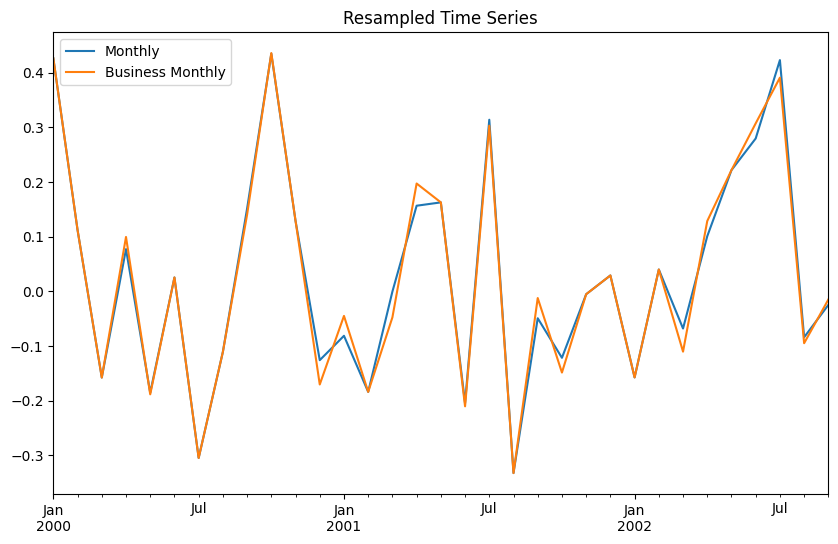

In [11]:
# Plot the resampled time series
fig, ax = plt.subplots(figsize=(10, 6))
monthly.plot(ax=ax, label='Monthly')
business_monthly.plot(ax=ax, label='Business Monthly')
ax.legend()
plt.title('Resampled Time Series')
plt.show()

### Merging Time Series Data

Let's explore how to merge time series data in pandas.

In [12]:
# Create two DataFrames with overlapping index
rng = pd.date_range('2000-01-01', periods=6)
df1 = pd.DataFrame(np.random.randn(6, 3), index=rng, columns=['A', 'B', 'C'])
df2 = df1.copy()

# Display the DataFrames
print("DataFrame 1:")
print(df1)
print("\nDataFrame 2:")
print(df2)

DataFrame 1:
                   A         B         C
2000-01-01  0.511241  0.259776  0.020557
2000-01-02 -0.053225 -0.342340 -2.175508
2000-01-03 -0.058469 -2.359112  0.258728
2000-01-04 -0.865927  0.279483 -2.265766
2000-01-05  1.052453  0.917737  0.609875
2000-01-06  0.403685 -0.165157 -0.446022

DataFrame 2:
                   A         B         C
2000-01-01  0.511241  0.259776  0.020557
2000-01-02 -0.053225 -0.342340 -2.175508
2000-01-03 -0.058469 -2.359112  0.258728
2000-01-04 -0.865927  0.279483 -2.265766
2000-01-05  1.052453  0.917737  0.609875
2000-01-06  0.403685 -0.165157 -0.446022


In [15]:
# Append the DataFrames
appended = pd.concat([df1, df2])
appended

,A,B,C
2000-01-01,0.511241,0.259776,0.020557
2000-01-02,-0.053225,-0.342340,-2.175508
2000-01-03,-0.058469,-2.359112,0.258728
2000-01-04,-0.865927,0.279483,-2.265766
2000-01-05,1.052453,0.917737,0.609875
2000-01-06,0.403685,-0.165157,-0.446022
2000-01-01,0.511241,0.259776,0.020557
2000-01-02,-0.053225,-0.342340,-2.175508
2000-01-03,-0.058469,-2.359112,0.258728
2000-01-04,-0.865927,0.279483,-2.265766


In [16]:
# Check for duplicate index values
appended.index.duplicated().any()

np.True_

In [17]:
# Reset the index to avoid duplicates
appended_reset = appended.reset_index()
appended_reset.head()

,index,A,B,C
0,2000-01-01,0.511241,0.259776,0.020557
1,2000-01-02,-0.053225,-0.342340,-2.175508
2,2000-01-03,-0.058469,-2.359112,0.258728
3,2000-01-04,-0.865927,0.279483,-2.265766
4,2000-01-05,1.052453,0.917737,0.609875


##### Conclusion

In this notebook, we've explored:

1. More details about NA values in pandas and differences with NumPy, including:
   - Why pandas chose a different approach than R for handling NA values
   - Differences in variance calculation between pandas and NumPy

2. Thread-safety considerations in pandas

3. How to handle byte-ordering issues when working with data from different systems

4. Practical examples from the pandas cookbook for time series operations, including:
   - Rolling apply with a DataFrame returning a scalar (VWAP calculation)
   - Working with DatetimeIndex to find the first day of the month
   - Resampling time series data to different frequencies
   - Merging time series data with overlapping indices

These concepts and examples provide valuable tools for working with time series data in pandas.